In [1]:
!pip install -q gymnasium[classic-control] torch numpy matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.9 MB/s eta 0:00:00


In [2]:
import random, math, os
from collections import deque
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import gymnasium as gym
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [8]:
env = gym.make("Pendulum-v1")
env.reset(seed=SEED)

state_dim = env.observation_space.shape[0]       # 3
action_dim = env.action_space.shape[0]           # 1
act_low  = torch.tensor(env.action_space.low,  device=device, dtype=torch.float32)
act_high = torch.tensor(env.action_space.high, device=device, dtype=torch.float32)
action_scale = (act_high - act_low) / 2.0        # typically 2.0
action_bias  = (act_high + act_low) / 2.0        # typically 0.0
log_action_scale_sum = torch.log(action_scale).sum().item()


In [9]:
class ReplayBuffer:
    def __init__(self, capacity=1_000_000):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)
    def __len__(self):
        return len(self.buffer)
    def push(self, s, a, r, ns, d):
        self.buffer.append((s, a, r, ns, d))
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        s, a, r, ns, d = map(np.array, zip(*batch))
        return (
            torch.tensor(s,  dtype=torch.float32, device=device),
            torch.tensor(a,  dtype=torch.float32, device=device),
            torch.tensor(r,  dtype=torch.float32, device=device).unsqueeze(-1),
            torch.tensor(ns, dtype=torch.float32, device=device),
            torch.tensor(d,  dtype=torch.float32, device=device).unsqueeze(-1),
        )


In [10]:
def mlp(in_dim, out_dim, hidden=256):
    return nn.Sequential(
        nn.Linear(in_dim, hidden), nn.ReLU(),
        nn.Linear(hidden, hidden), nn.ReLU(),
        nn.Linear(hidden, out_dim),
    )

class GaussianPolicy(nn.Module):
    def __init__(self, state_dim, action_dim, hidden=256, log_std_min=-20, log_std_max=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
        )
        self.mu = nn.Linear(hidden, action_dim)
        self.log_std = nn.Linear(hidden, action_dim)
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max

    def forward(self, state):
        z = self.net(state)
        mu = self.mu(z)
        log_std = torch.clamp(self.log_std(z), self.log_std_min, self.log_std_max)
        std = log_std.exp()
        return mu, std

    def sample(self, state):
        mu, std = self.forward(state)
        normal = Normal(mu, std)
        u = normal.rsample()                 # reparameterization
        a_tanh = torch.tanh(u)
        action = a_tanh * action_scale + action_bias
        # log-prob with tanh-squash + scaling correction
        log_prob = normal.log_prob(u) - torch.log(1 - a_tanh.pow(2) + 1e-6)
        log_prob = log_prob.sum(dim=-1, keepdim=True) - log_action_scale_sum
        return action, log_prob, mu, std

    @torch.no_grad()
    def act_deterministic(self, state_np):
        s = torch.tensor(state_np, dtype=torch.float32, device=device).unsqueeze(0)
        mu, _ = self.forward(s)
        a = torch.tanh(mu) * action_scale + action_bias
        return a.squeeze(0).cpu().numpy()


In [11]:
class QCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden=256):
        super().__init__()
        self.q1 = mlp(state_dim + action_dim, 1, hidden)
        self.q2 = mlp(state_dim + action_dim, 1, hidden)
    def forward(self, s, a):
        sa = torch.cat([s, a], dim=-1)
        return self.q1(sa), self.q2(sa)


In [12]:
class SACAgent:
    def __init__(self, state_dim, action_dim, gamma=0.99, tau=0.005,
                 actor_lr=3e-4, critic_lr=3e-4, alpha_lr=3e-4,
                 target_entropy=None):
        self.gamma = gamma
        self.tau = tau

        self.actor = GaussianPolicy(state_dim, action_dim).to(device)
        self.critic = QCritic(state_dim, action_dim).to(device)
        self.critic_target = QCritic(state_dim, action_dim).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())

        self.actor_opt = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_opt = optim.Adam(self.critic.parameters(), lr=critic_lr)

        # temperature alpha (entropy) — automatic tuning
        if target_entropy is None:
            target_entropy = -float(action_dim)
        self.target_entropy = target_entropy
        self.log_alpha = torch.tensor(0.0, requires_grad=True, device=device)
        self.alpha_opt = optim.Adam([self.log_alpha], lr=alpha_lr)

    @property
    def alpha(self):
        return self.log_alpha.exp()

    def update(self, batch):
        states, actions, rewards, next_states, dones = batch

        # ----- Critic update -----
        with torch.no_grad():
            next_actions, next_logp, _, _ = self.actor.sample(next_states)
            q1_t, q2_t = self.critic_target(next_states, next_actions)
            q_target_min = torch.min(q1_t, q2_t)
            target = rewards + self.gamma * (1.0 - dones) * (q_target_min - self.alpha * next_logp)

        q1, q2 = self.critic(states, actions)
        critic_loss = nn.MSELoss()(q1, target) + nn.MSELoss()(q2, target)
        self.critic_opt.zero_grad(); critic_loss.backward(); self.critic_opt.step()

        # ----- Actor update -----
        new_actions, logp, _, _ = self.actor.sample(states)
        q1_pi, q2_pi = self.critic(states, new_actions)
        q_pi = torch.min(q1_pi, q2_pi)
        actor_loss = (self.alpha * logp - q_pi).mean()
        self.actor_opt.zero_grad(); actor_loss.backward(); self.actor_opt.step()

        # ----- Alpha (temperature) update -----
        alpha_loss = -(self.log_alpha * (logp + self.target_entropy).detach()).mean()
        self.alpha_opt.zero_grad(); alpha_loss.backward(); self.alpha_opt.step()

        # ----- Soft update target critics -----
        with torch.no_grad():
            for p_t, p in zip(self.critic_target.parameters(), self.critic.parameters()):
                p_t.data.mul_(1 - self.tau)
                p_t.data.add_(self.tau * p.data)

        return {
            "critic_loss": float(critic_loss.item()),
            "actor_loss": float(actor_loss.item()),
            "alpha": float(self.alpha.item()),
        }

    @torch.no_grad()
    def act(self, state_np, eval_mode=False):
        s = torch.tensor(state_np, dtype=torch.float32, device=device).unsqueeze(0)
        if eval_mode:
            return self.actor.act_deterministic(state_np)
        a, _, _, _ = self.actor.sample(s)
        return a.squeeze(0).cpu().numpy()


Step   5000 | AvgReturn(10ep): -1067.04 | Buffer: 5000
Step  10000 | AvgReturn(10ep): -183.49 | Buffer: 10000
Step  15000 | AvgReturn(10ep): -134.18 | Buffer: 15000
Step  20000 | AvgReturn(10ep): -145.18 | Buffer: 20000
Step  25000 | AvgReturn(10ep): -177.21 | Buffer: 25000
Step  30000 | AvgReturn(10ep): -205.40 | Buffer: 30000
Step  35000 | AvgReturn(10ep): -175.46 | Buffer: 35000
Step  40000 | AvgReturn(10ep): -145.72 | Buffer: 40000
Step  45000 | AvgReturn(10ep): -213.09 | Buffer: 45000
Step  50000 | AvgReturn(10ep): -121.39 | Buffer: 50000
Step  55000 | AvgReturn(10ep): -163.14 | Buffer: 55000
Step  60000 | AvgReturn(10ep): -184.15 | Buffer: 60000
Step  65000 | AvgReturn(10ep): -196.47 | Buffer: 65000
Step  70000 | AvgReturn(10ep): -152.14 | Buffer: 70000
Step  75000 | AvgReturn(10ep): -166.51 | Buffer: 75000
Step  80000 | AvgReturn(10ep): -160.41 | Buffer: 80000
Step  85000 | AvgReturn(10ep): -156.74 | Buffer: 85000
Step  90000 | AvgReturn(10ep): -131.70 | Buffer: 90000
Step  9500

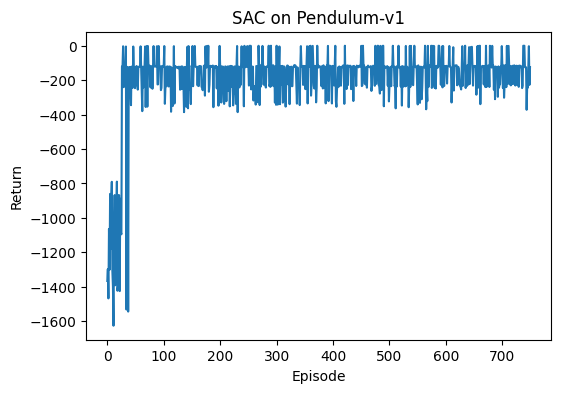

In [13]:
buffer = ReplayBuffer(capacity=1_000_000)
agent  = SACAgent(state_dim, action_dim)

total_steps     = 150_000
start_random    = 5_000       # langkah awal pakai aksi acak untuk eksplorasi
update_after    = 1_000
update_every    = 1           # berapa kali update per langkah env
batch_size      = 256
max_ep_steps    = 200
log_interval    = 5000

ep_returns, history = [], []
state, info = env.reset(seed=SEED)
ep_ret, ep_len = 0.0, 0

for t in range(1, total_steps + 1):
    if t < start_random:
        action = env.action_space.sample()
    else:
        action = agent.act(state, eval_mode=False)

    next_state, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    buffer.push(state, action, reward, next_state, float(done))

    state = next_state
    ep_ret += reward; ep_len += 1

    # update
    if (t >= update_after) and (len(buffer) >= batch_size):
        for _ in range(update_every):
            batch = buffer.sample(batch_size)
            agent.update(batch)

    if done or ep_len >= max_ep_steps:
        history.append(ep_ret)
        state, info = env.reset()
        ep_ret, ep_len = 0.0, 0

    if t % log_interval == 0 and len(history) >= 10:
        print(f"Step {t:6d} | AvgReturn(10ep): {np.mean(history[-10:]):7.2f} | Buffer: {len(buffer)}")

plt.figure(figsize=(6,4))
plt.plot(history)
plt.xlabel("Episode"); plt.ylabel("Return"); plt.title("SAC on Pendulum-v1")
plt.show()


In [14]:
@torch.no_grad()
def evaluate(env, agent, episodes=10):
    scores = []
    for ep in range(episodes):
        s, info = env.reset(seed=SEED + 1000 + ep)
        total = 0.0; done = False
        while not done:
            a = agent.act(s, eval_mode=True)
            s, r, terminated, truncated, info = env.step(a)
            total += r
            done = terminated or truncated
        scores.append(total)
    return float(np.mean(scores)), float(np.std(scores))

avg, std = evaluate(env, agent, episodes=10)
print(f"Eval average return (10 eps): {avg:.2f} ± {std:.2f}")


Eval average return (10 eps): -142.22 ± 99.74


In [15]:
POLICY_PATH = "sac_pendulum_actor.pt"
CRITIC_PATH = "sac_pendulum_critics.pt"

torch.save(agent.actor.state_dict(),  POLICY_PATH)
torch.save(agent.critic.state_dict(), CRITIC_PATH)
print("Model disimpan:", POLICY_PATH, "&&", CRITIC_PATH)

# Memuat kembali:
# actor2 = GaussianPolicy(state_dim, action_dim).to(device)
# actor2.load_state_dict(torch.load(POLICY_PATH, map_location=device))
# actor2.eval()


Model disimpan: sac_pendulum_actor.pt && sac_pendulum_critics.pt


In [16]:
from gymnasium.wrappers import RecordVideo
import os, shutil, glob
from IPython.display import HTML

VID_DIR = "sac_videos"
if os.path.exists(VID_DIR): shutil.rmtree(VID_DIR)

venv = RecordVideo(gym.make("Pendulum-v1", render_mode="rgb_array"),
                   video_folder=VID_DIR, episode_trigger=lambda e: True)

s, info = venv.reset(seed=SEED + 2024)
done = False
while not done:
    a = agent.act(s, eval_mode=True)
    s, r, terminated, truncated, info = venv.step(a)
    done = terminated or truncated
venv.close()

mp4s = sorted(glob.glob(f"{VID_DIR}/*.mp4"))
print("Video:", mp4s[-1] if mp4s else "tidak ditemukan")
if mp4s:
    HTML(f"""
    <video width="480" controls>
        <source src="{mp4s[-1]}" type="video/mp4">
    </video>
    """)


Video: sac_videos/rl-video-episode-0.mp4
